In [1]:
"""Preprocesses data for training.

Preferrably, run using Jupyter Notebook.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
# Read raw data from the excel file.
raw_data = pd.read_excel(
    "data/ouse93-96-raw-data.xlsx",
    index_col=0,
    header=1,
    usecols='A:I'
)

In [3]:
# Convert columns to float values. Turn non-numeric values into np.nan.
for column in raw_data.columns[1:]:
    raw_data[column] = pd.to_numeric(raw_data[column], errors='coerce')

In [4]:
# Convert negative values into np.nan.
raw_data = raw_data.mask(raw_data < 0, np.nan)

In [5]:
# Print all rows with NAN values.
raw_data[raw_data.isna().any(axis=1)]

,Crakehill,Skip Bridge,Westwick,Skelton,Arkengarthdale,East Cowton,Malham Tarn,Snaizeholme
1993-02-13,NaN,5.476,11.051,30.73,0.0,0.0,0.0,0.0
1993-03-15,NaN,2.546,7.179,18.06,11.2,0.0,86.0,19.2
1993-03-16,NaN,2.494,7.232,17.16,0.8,0.0,12.8,8.0
1993-04-07,22.90,4.159,26.603,NaN,2.4,0.0,0.0,3.2
1993-04-27,24.40,11.684,22.181,73.96,NaN,0.0,0.0,0.0
1995-03-01,80.60,19.096,100.761,174.00,17.6,NaN,51.2,21.6
1996-02-09,12.70,NaN,7.576,20.58,0.0,37.6,12.0,14.4
1996-04-18,7.61,NaN,13.918,16.84,0.8,4.8,47.2,32.0


In [6]:
# Calculate mean and standard deviation for each numeric column.
standard_deviations = raw_data.std()
means = raw_data.mean()

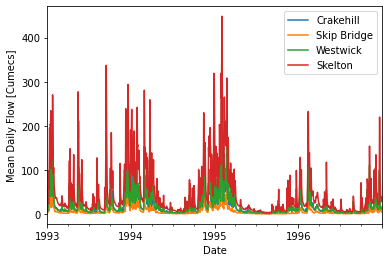

In [7]:
# Plot river flow columns.
raw_data[['Crakehill', 'Skip Bridge', 'Westwick', 'Skelton']].plot(xlabel="Date", ylabel="Mean Daily Flow [Cumecs]")
plt.savefig('figures/river-flow.png') 

In [8]:
# Find the values that lies the furthest from the mean from Mean Daily Flow columns.
skelton_max = raw_data['Skelton'].max()
print(raw_data['Skelton'].sort_values(ascending=False).head())
print((skelton_max - means['Skelton']) / standard_deviations['Skelton'])


1995-02-01    448.1
1995-02-02    362.3
1993-09-15    337.2
1995-01-29    319.6
1994-12-29    319.1
Name: Skelton, dtype: float64
7.197730720717447


1995-02-11    5000.0
Name: Arkengarthdale, dtype: float64
1995-02-28    9000.0
Name: East Cowton, dtype: float64
1996-01-10    80000.0
Name: Malham Tarn, dtype: float64


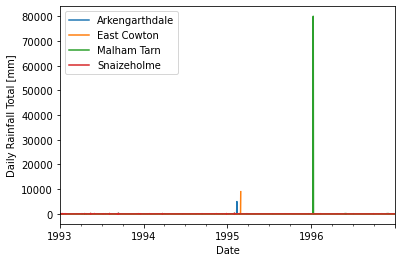

In [9]:
# Plot river flow columns.
raw_data[['Arkengarthdale', 'East Cowton', 'Malham Tarn', 'Snaizeholme']].plot(xlabel="Date", ylabel="Daily Rainfall Total [mm]")
plt.savefig('figures/rainfall.png')

print(raw_data['Arkengarthdale'].sort_values(ascending=False).head(1))
print(raw_data['East Cowton'].sort_values(ascending=False).head(1))
print(raw_data['Malham Tarn'].sort_values(ascending=False).head(1))

In [10]:
# Interpolate outliers.
for column in raw_data[['Arkengarthdale', 'East Cowton', 'Malham Tarn']].columns:
    column_values = raw_data[column]
    column_max_id = column_values.idxmax()
    column_values.loc[column_max_id] = np.nan

    """
    column_values = column_values.mask(
        column_values > means[column] + 3 * standard_deviations[column],
        np.nan
    )
    
    # If this is a river flow column, check the lower bound as well.
    if column in ['Crakehill', 'Skip Bridge', 'Westwick', 'Skelton']:
        column_values = column_values.mask(
            column_values < means[column] - 3 * standard_deviations[column],
            np.nan
        )
    raw_data[column] = column_values.interpolate(method="linear") 
    """

In [11]:
# Imputate spurious data.
raw_data = raw_data.interpolate(method="linear")

In [12]:
# Print all rows with NAN values.
raw_data[raw_data.isna().any(axis=1)]

,Crakehill,Skip Bridge,Westwick,Skelton,Arkengarthdale,East Cowton,Malham Tarn,Snaizeholme


In [13]:
# Print values interpolated for outliers.
print(raw_data.loc["1995-02-11", "Arkengarthdale"])
print(raw_data.loc["1995-02-28", "East Cowton"])
print(raw_data.loc["1996-01-10", "Malham Tarn"])


15.6
0.0
4.4


In [14]:
# Print all rows with NAN values.
raw_data[raw_data.isna().any(axis=1)]

,Crakehill,Skip Bridge,Westwick,Skelton,Arkengarthdale,East Cowton,Malham Tarn,Snaizeholme


In [15]:
# Add a column for Mean Daily Flow in Skelton one day before. 
raw_data.insert(0, 'Skelton T-1', raw_data['Skelton'])

In [16]:
# Make predictand column the rightmost column.
columns = raw_data.columns
skelton_column = raw_data.pop("Skelton")
raw_data.insert(len(columns) - 1, skelton_column.name, skelton_column)

In [17]:
# Explore the correlations between potential predictors and the predictand.

print(raw_data.corr())
# Lag Mean Daily Flow potential predictor columns by one day.
raw_data['Skelton T-1'] = raw_data['Skelton T-1'].shift(periods=1, freq="D")
raw_data['Crakehill'] = raw_data['Crakehill'].shift(periods=1, freq="D")
raw_data['Skip Bridge'] = raw_data['Skip Bridge'].shift(periods=1, freq="D")
raw_data['Westwick'] = raw_data['Westwick'].shift(periods=1, freq="D")

# Lag Rainfall columns by one day.
raw_data['Arkengarthdale'] = raw_data['Arkengarthdale'].shift(periods=1, freq="D")
raw_data['East Cowton'] = raw_data['East Cowton'].shift(periods=1, freq="D")
raw_data['Malham Tarn'] = raw_data['Malham Tarn'].shift(periods=1, freq="D")
raw_data['Snaizeholme'] = raw_data['Snaizeholme'].shift(periods=1, freq="D")
print(raw_data.corr())

                Skelton T-1  Crakehill  Skip Bridge  Westwick  Arkengarthdale  \
Skelton T-1        1.000000   0.972963     0.947450  0.886928        0.297903   
Crakehill          0.972963   1.000000     0.930377  0.899519        0.332016   
Skip Bridge        0.947450   0.930377     1.000000  0.864887        0.371388   
Westwick           0.886928   0.899519     0.864887  1.000000        0.472752   
Arkengarthdale     0.297903   0.332016     0.371388  0.472752        1.000000   
East Cowton        0.181339   0.236052     0.256521  0.290600        0.596908   
Malham Tarn        0.293830   0.308667     0.327098  0.482948        0.593524   
Snaizeholme        0.345434   0.367000     0.366891  0.558024        0.633283   
Skelton            1.000000   0.972963     0.947450  0.886928        0.297903   

                East Cowton  Malham Tarn  Snaizeholme   Skelton  
Skelton T-1        0.181339     0.293830     0.345434  1.000000  
Crakehill          0.236052     0.308667     0.367000  0.

In [18]:
# Drop rows containing missing values after lagging.
raw_data = raw_data.dropna()
raw_data

,Skelton T-1,Crakehill,Skip Bridge,Westwick,Arkengarthdale,East Cowton,Malham Tarn,Snaizeholme,Skelton
1993-01-02,26.10,10.40,4.393,9.291,0.0,0.0,0.0,4.0,24.86
1993-01-03,24.86,9.95,4.239,8.622,0.0,0.0,0.8,0.0,23.60
1993-01-04,23.60,9.46,4.124,8.057,0.0,0.0,0.8,0.0,23.47
1993-01-05,23.47,9.41,4.363,7.925,2.4,24.8,0.8,61.6,60.70
1993-01-06,60.70,26.30,11.962,58.704,11.2,5.6,33.6,111.2,98.01
...,...,...,...,...,...,...,...,...,...
1996-12-27,33.06,11.70,6.075,12.671,0.0,0.8,0.0,0.0,29.52
1996-12-28,29.52,10.90,5.721,11.558,1.6,14.4,8.8,3.2,28.67
1996-12-29,28.67,11.10,5.486,11.411,11.2,11.2,4.8,4.8,29.31
1996-12-30,29.31,12.10,5.329,11.781,3.2,4.8,0.0,0.8,34.28


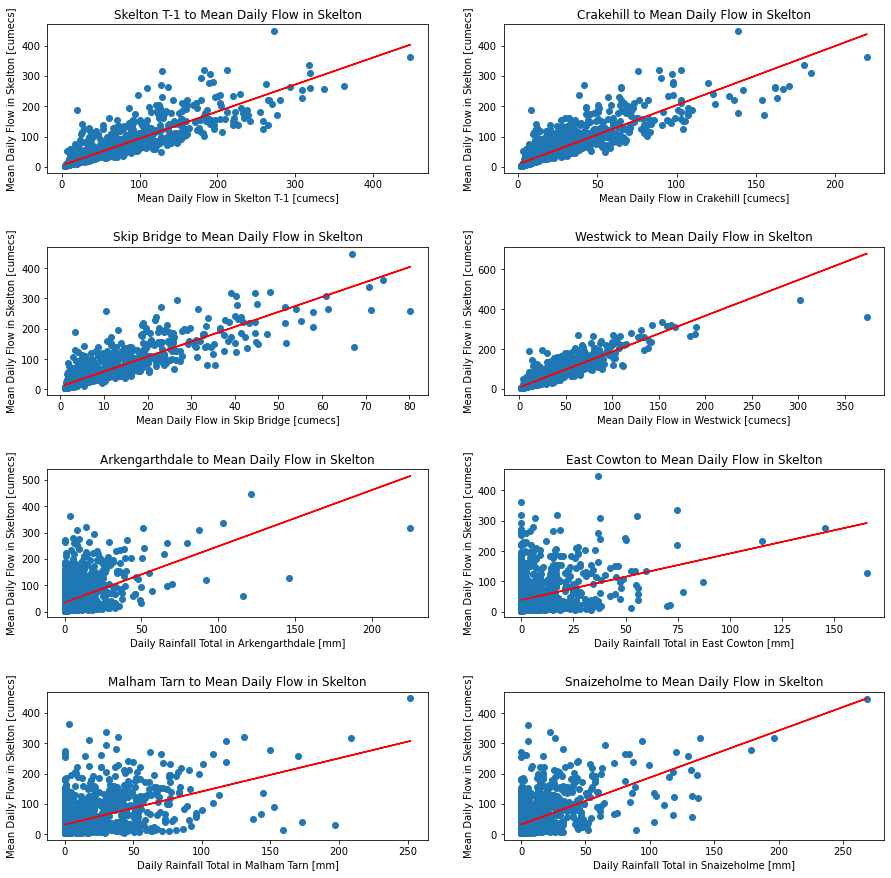

In [19]:
# Plot correlation between lagged predictors and the predictand.

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,15))

plt.subplots_adjust(wspace=0.2, hspace=0.5)

mean_daily_flow_columns = ["Skelton T-1", "Crakehill", "Skip Bridge", "Westwick"]
daily_rainfall_total_columns = ["Arkengarthdale", "East Cowton", "Malham Tarn", "Snaizeholme"]


for i in range(len(raw_data.loc[:, raw_data.columns != "Skelton"].columns)):
    column_name = raw_data.iloc[:, i].name
    x = raw_data.iloc[:, i].values.reshape(-1, 1)
    y = raw_data['Skelton'].values.reshape(-1, 1)
    linear_regressor = LinearRegression()
    linear_regressor.fit(x, y)
    y_pred = linear_regressor.predict(x)
    axes[i // 2][ i % 2].scatter(x, y)
    axes[i // 2][ i % 2].plot(x, y_pred, color='red')
    # Decide on x-label.
    if column_name in mean_daily_flow_columns:
        axes[i // 2][ i % 2].set_xlabel(f"Mean Daily Flow in {column_name} [cumecs]")
    elif column_name in daily_rainfall_total_columns:
        axes[i // 2][ i % 2].set_xlabel(f"Daily Rainfall Total in {column_name} [mm]")
    axes[i // 2][ i % 2].set_ylabel('Mean Daily Flow in Skelton [cumecs]')
    axes[i // 2][ i % 2].set_title(f"{column_name} to Mean Daily Flow in Skelton")

plt.savefig('figures/predictors-predictand.png')
    


In [20]:
# Split the data into into training-validation and test sets.
train_and_validation, test = train_test_split(raw_data, test_size=0.2)

# Calculate min and max values from training-validation set.
max_values = train_and_validation.max(axis=0)
min_values = train_and_validation.min(axis=0)
print(max_values)
print(min_values)

# Split training-validation set into training and validation sets.
train, validation = train_test_split(train_and_validation, test_size=0.25)
train

Skelton T-1       448.100
Crakehill         220.000
Skip Bridge        80.244
Westwick          374.061
Arkengarthdale    121.600
East Cowton       145.600
Malham Tarn       252.000
Snaizeholme       268.800
Skelton           448.100
dtype: float64
Skelton T-1       3.694
Crakehill         2.060
Skip Bridge       1.002
Westwick          1.954
Arkengarthdale    0.000
East Cowton       0.000
Malham Tarn       0.000
Snaizeholme       0.000
Skelton           3.748
dtype: float64


,Skelton T-1,Crakehill,Skip Bridge,Westwick,Arkengarthdale,East Cowton,Malham Tarn,Snaizeholme,Skelton
1996-06-20,8.271,3.89,1.8060,3.752,0.0,0.0,4.0,0.0,7.797
1996-05-20,13.340,6.82,2.7770,5.984,8.8,24.0,22.4,4.8,13.400
1995-11-30,22.970,10.20,1.9010,10.690,0.8,0.8,3.2,0.8,21.250
1993-09-12,61.800,19.70,4.5380,27.108,8.0,0.0,24.0,12.4,34.910
1994-02-17,35.090,13.60,6.1320,12.710,8.0,7.2,12.0,1.6,36.730
...,...,...,...,...,...,...,...,...,...
1996-02-10,20.580,12.70,6.7105,7.576,0.0,37.6,12.0,14.4,60.620
1995-02-21,154.700,56.50,24.6490,68.903,24.8,0.8,36.0,32.8,159.100
1995-02-15,182.600,71.30,25.7800,67.655,12.8,5.6,18.4,25.6,168.200
1995-11-20,21.680,9.66,1.7730,9.360,0.0,0.0,0.0,0.0,18.170


In [21]:
def standardise(x: pd.Series, max_value: float, min_value: float):
    """Standardises data using minimum and maximum values.
    
    Args:
    x: A pandas.Series instance.
    max_value: A maximum value for the standardisation formula.
    min_value: A minimum value for the standardisation formula.
    
    Returns:
    pandas.Series.
    """
    return 0.8 * ((x - min_value) / (max_value - min_value)) + 0.1
    
# Standardise the data.
standardised_data_sets = []
for data_set in [train, validation, test]:
    standardised_columns = []
    for column in data_set.columns:
        standardised_column = data_set.loc[:, column].apply(standardise, args=(max_values[column], min_values[column]))
        standardised_columns.append(standardised_column)
    standardised_data_set = pd.concat(standardised_columns, axis=1)
    standardised_data_sets.append(standardised_data_set)
        
train_standardised = standardised_data_sets[0]
validation_standardised = standardised_data_sets[0]
test_standardised = standardised_data_sets[0]
train_standardised

,Skelton T-1,Crakehill,Skip Bridge,Westwick,Arkengarthdale,East Cowton,Malham Tarn,Snaizeholme,Skelton
1996-06-20,0.108239,0.106717,0.108117,0.103866,0.100000,0.100000,0.112698,0.100000,0.107290
1996-05-20,0.117364,0.117473,0.117920,0.108664,0.157895,0.231868,0.171111,0.114286,0.117377
1995-11-30,0.134700,0.129880,0.109076,0.118782,0.105263,0.104396,0.110159,0.102381,0.131510
1993-09-12,0.204600,0.164752,0.135698,0.154079,0.152632,0.100000,0.176190,0.136905,0.156103
1994-02-17,0.156518,0.142360,0.151791,0.123125,0.152632,0.139560,0.138095,0.104762,0.159380
...,...,...,...,...,...,...,...,...,...
1996-02-10,0.130397,0.139057,0.157631,0.112087,0.100000,0.306593,0.138095,0.142857,0.202391
1995-02-21,0.371834,0.299835,0.338732,0.243935,0.263158,0.104396,0.214286,0.197619,0.379692
1995-02-15,0.422059,0.354162,0.350150,0.241252,0.184211,0.130769,0.158413,0.176190,0.396075
1995-11-20,0.132378,0.127898,0.107784,0.115922,0.100000,0.100000,0.100000,0.100000,0.125965
